## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [13]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


In [ ]:
# I would clean the tokens, I would remove words like "and" and "the", and punctuation or symbols/numbers.
# Then, I could one-hot-encode the tokens as predictors and run algorithms.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [23]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

<Axes: >

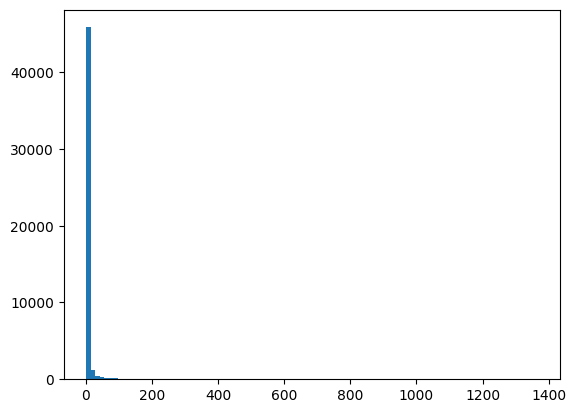

In [24]:
gdf = pd.DataFrame(token_freq, columns=['token','count'])
gdf['count'].hist(grid=False, bins=100)

In [25]:
gdf['count'].describe()

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


In [ ]:
# Most tokens appear once, and multiple appear more than 10x. The maximum token appears 1365 times.
# This makes it difficult to determine which are scams.

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [42]:
df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
x = df.drop('Email Type', axis=1)

In [49]:
#1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=125)

In [52]:
#2
lm_0 = LinearRegression(fit_intercept=False).fit(x_train,y_train)
y_hat_test_0=lm_0.predict(x_test)
y_hat_train_0=lm_0.predict(x_train)
print('train: ', r2_score(y_train, y_hat_train_0))
print('test: ', r2_score(y_test, y_hat_test_0))

train:  0.6948655461957206
test:  -1.4727860414155143e+22


In [54]:
#3
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_, 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('value', ascending=False).head(10)

,variable,value,abs
421,1995,1.158467e+13,1.158467e+13
237,1999,7.479118e+12,7.479118e+12
33,2001,7.316781e+12,7.316781e+12
318,100,7.169511e+12,7.169511e+12
1034,underline;,6.764639e+12,6.764639e+12
1825,"30,",5.151302e+12,5.151302e+12
96,000,4.939700e+12,4.939700e+12
40,2000,4.910520e+12,4.910520e+12
74,"2002,",4.909072e+12,4.909072e+12
2122,"08,",4.709292e+12,4.709292e+12


In [ ]:
# the top entries are numbers. This model seems to be overfitting.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

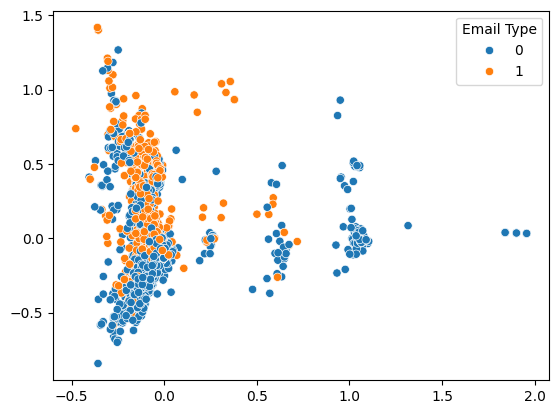

In [56]:
reduction = PCA(n_components=2).fit(x_train)
Z_train = reduction.transform(x_train)
Z_test = reduction.transform(x_test)
sns.scatterplot(x=Z_test[:,0], y=Z_test[:,1],hue=y_test)

In [ ]:
# The orange dots are the scam emails.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [60]:
reduction = PCA(n_components=2610).fit(x_train)
Z_train = reduction.transform(x_train)
Z_test = reduction.transform(x_test)

lm_k = LinearRegression(fit_intercept=False).fit(Z_train,y_train)
y_hat_test=lm_k.predict(Z_test)
y_hat_train=lm_k.predict(Z_train)

print('train r2: ', r2_score(y_hat_train, y_train))
print('test r2: ', r2_score(y_hat_test, y_test))

train r2:  -0.14805164032756069
test r2:  -0.1989500815072378


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

In [ ]:
# After applying PCA, the features become independent of each other, so we don't ened to worry about mutli-collinearity.
# PCa lets us pick how many components to keep up to 2711 which makes the process easier.
# The downside is that even though we can understand the meaning of the original features, PCA components are abstract.